In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import MDAnalysis as mda
from tqdm import tqdm
from numpy import linalg as LA

In [2]:
runs = sorted(glob.glob("../../../traj_out/protein_dimer/dimer_*.pdb"))

In [3]:
def dist_pbc(a, b, box):
    """
    calculate distance between two points
    in PBC box
    """
    assert len(a) == len(b)
    box = box[:len(a)]
    a = a % box
    b = b % box
    dist_vec = np.abs(a - b)
    dist_vec = np.abs(dist_vec - box * (dist_vec > box/2))
    return LA.norm(dist_vec)

In [4]:
df = []

for run in runs:
    pdb_file = run
    dcd_file = run.replace("pdb", "dcd")

    run_base = os.path.basename(run)

    run_label = run_base.split("_")[2]
#     if int(run_label) < 14:
#         continue

    mda_traj = mda.Universe(pdb_file, dcd_file)

    mpro_a = mda_traj.segments[0].atoms
    mpro_b = mda_traj.segments[1].atoms
    dist_list = []
    for ts in tqdm(mda_traj.trajectory):
#         dist_vec = mpro_a.atoms.center_of_mass() - mpro_b.atoms.center_of_mass()
        dist = dist_pbc(mpro_a.center_of_mass(), mpro_b.center_of_mass(), mpro_a.dimensions)

        dist_list += [dist]
    df.append({'sys_name': run_base,
#                    'frame': ts.frame,
#                    'dist_vec': dist_vec,
               'dist': dist_list})

100%|██████████| 20000/20000 [00:16<00:00, 1181.44it/s]


In [5]:
df = pd.DataFrame(df)
df

,sys_name,dist
0,dimer_1M42_0.pdb,"[26.024591594046754, 25.87923282606178, 25.922..."
1,dimer_1M42_1.pdb,"[26.43616740722504, 26.476917208407702, 26.457..."
2,dimer_1M42_2.pdb,"[26.30765561336222, 26.43535473344345, 25.9752..."
3,dimer_1M42_3.pdb,"[26.094246139183713, 26.453904713337046, 26.39..."
4,dimer_2M42_0.pdb,"[26.279927654194285, 26.256160109089606, 26.15..."
5,dimer_2M42_1.pdb,"[26.465439594748155, 26.18282224430925, 26.391..."
6,dimer_2M42_2.pdb,"[26.260788244344912, 26.194195769968438, 26.29..."
7,dimer_2M42_3.pdb,"[26.620859019963557, 26.44776695650618, 26.185..."


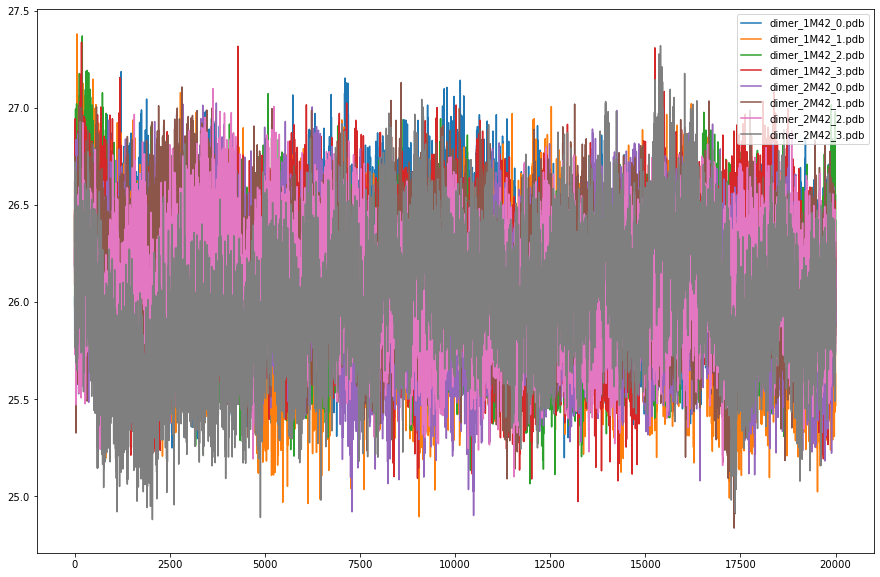

In [6]:
fig, ax = plt.subplots(figsize=(15,10)) 
n_traj = 0 

for i, row in df.iterrows(): 
    ax.plot(row['dist'], label=row['sys_name']) 
plt.legend()
plt.savefig('dist.pdf')

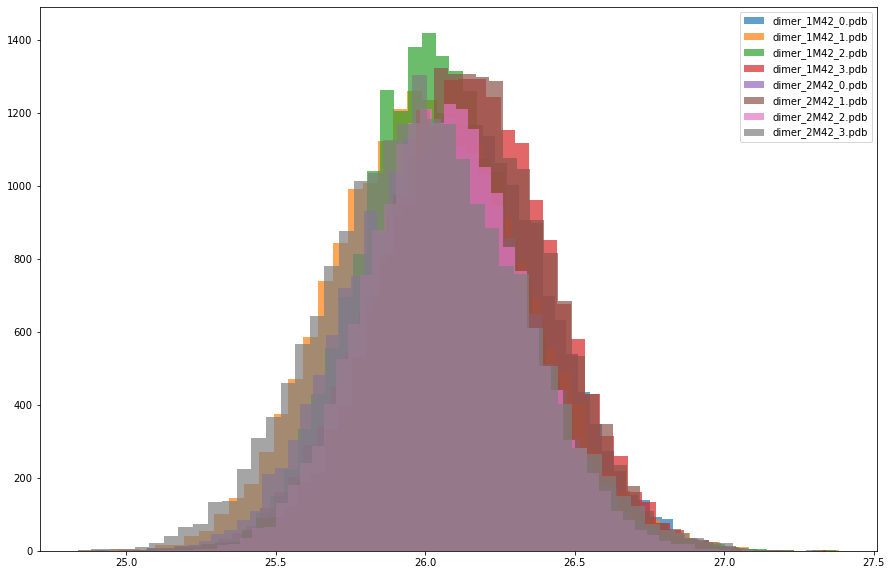

In [7]:
fig, ax = plt.subplots(figsize=(15,10)) 
n_traj = 0 

for i, row in df.iterrows(): 
    _ = ax.hist(row['dist'], bins=50, label=row['sys_name'], alpha=.7) 
plt.legend()
plt.savefig('dist_hist.pdf')